# Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path
import pandas as pd
pd.options.display.float_format = '{:.5f}'.format

from tqdm import tqdm

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [3]:
data = pd.read_csv("data/1.kospi200futures_TI.csv")

In [4]:
data

,date,time,close,07_RSI,10_RSI,13_RSI,16_RSI,19_RSI,22_RSI,25_RSI,...,34_RETURN,37_RETURN,40_RETURN,43_RETURN,46_RETURN,49_RETURN,52_RETURN,1_updown,5_updown,21_updown
0,20070102,1030,187.15000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,0.00000,1.00000
1,20070102,1100,186.75000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,1.00000
2,20070102,1130,187.35000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,1.00000,1.00000
3,20070102,1200,187.45000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,1.00000,1.00000
4,20070102,1230,187.35000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,1.00000,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49442,20211230,1400,394.75000,36.80619,38.73875,40.76849,42.46764,43.86524,45.02316,45.98735,...,0.00140,0.00254,0.00025,-0.00076,-0.00278,-0.00152,-0.00567,1.00000,NaN,NaN
49443,20211230,1430,394.30000,31.83808,35.21610,37.95898,40.10141,41.80908,43.20047,44.34949,...,0.00063,-0.00202,-0.00051,-0.00127,-0.00379,-0.00316,-0.00555,1.00000,NaN,NaN
49444,20211230,1500,393.75000,26.69923,31.34528,34.78497,37.38571,39.42490,41.07148,42.42574,...,-0.00152,-0.00101,-0.00139,-0.00316,-0.00392,-0.00531,-0.00215,0.00000,NaN,NaN
49445,20211230,1530,394.45000,40.87041,40.58118,41.52639,42.65756,43.73532,44.70485,45.55663,...,-0.00025,0.00063,0.00178,-0.00051,-0.00152,-0.00354,-0.00228,1.00000,NaN,NaN


In [5]:
drop_col = ["date", "time","1_updown", "5_updown", "21_updown", "close"]

features = data[data.columns.difference(drop_col)]
drops = data[drop_col]

# Hierarchical Clustering

In [6]:
feature_list = list(set(features.columns.str.split('_').str[-1]))
features_num = sorted(list(set(features.columns.str.split('_').str[0])), key=int)

In [7]:
def cluster_features(data, labels, ax, title):
    data = StandardScaler().fit_transform(data)
    pairwise_distance = pdist(data)
    Z = linkage(data, 'ward')
    c, coph_dists = cophenet(Z, pairwise_distance)
    dend = dendrogram(Z,
                      labels=labels,
                      orientation='top',
                      leaf_rotation=0.,
                      leaf_font_size=8.,
                      ax=ax)
    ax.set_title(title)
    return dend['ivl']

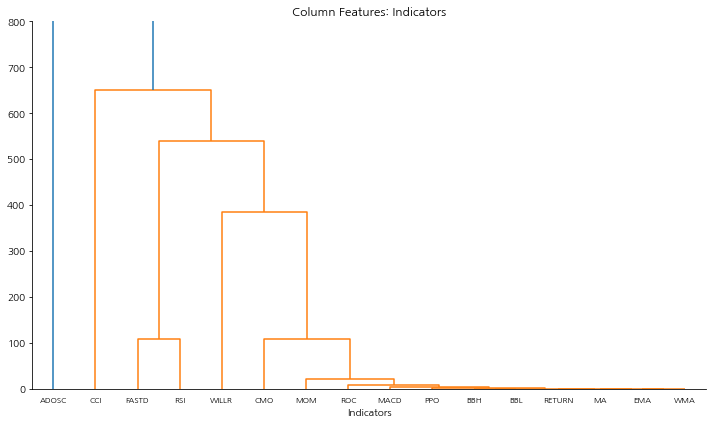

In [8]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

labels = sorted(feature_list)
title = 'Column Features: Indicators'
col_order = cluster_features(features.dropna().values.reshape(-1, 16).T,
                             labels,
                             ax,
                             title)

title = 'Row Features: Indicator Parameters'
ax.set_xlabel('Indicators')
ax.set_ylim([0, 800])
sns.despine()
fig.tight_layout()

In [9]:
feature_order = [f'{i}_{j}' for i in features_num for j in col_order]
features = features.loc[:, feature_order]

data_clustered = pd.concat([features, drops], axis=1)
data_clustered.to_csv("data/2.kospi200futures_clustered.csv", index=False)

In [10]:
data_clustered.iloc[:,:16].describe()

,07_ADOSC,07_CCI,07_FASTD,07_RSI,07_WILLR,07_CMO,07_MOM,07_ROC,07_MACD,07_PPO,07_BBH,07_BBL,07_RETURN,07_MA,07_EMA,07_WMA
count,49437.00000,49441.00000,49439.00000,49440.00000,49441.00000,49440.00000,49440.00000,49440.00000,49416.00000,49422.00000,49441.00000,49441.00000,49440.00000,49440.00000,49440.00000,49440.00000
mean,950.70476,3.50509,52.10391,51.49662,-47.89201,2.99325,0.02932,0.01513,-0.00000,0.01307,0.00533,0.00538,0.00015,0.00002,0.00002,0.00002
std,11849.66248,102.21181,26.28465,18.96391,29.84075,37.92781,2.26086,0.95632,1.00001,0.59879,0.00763,0.00692,0.00956,0.00137,0.00136,0.00153
min,-106881.45898,-233.33333,-0.00000,2.10564,-100.00000,-95.78871,-21.50000,-10.58079,-8.57432,-5.77471,-0.00803,-0.01415,-0.10581,-0.01568,-0.02263,-0.02360
25%,-5276.35891,-79.03989,29.62963,37.92769,-75.00000,-24.14462,-0.90000,-0.34958,-0.53241,-0.26234,0.00132,0.00141,-0.00350,-0.00050,-0.00046,-0.00052
50%,875.08154,7.94066,52.55537,51.86411,-47.05882,3.72822,0.05000,0.01995,0.06731,0.04827,0.00299,0.00319,0.00020,0.00003,0.00005,0.00004
75%,7287.72310,85.05237,75.02086,65.25001,-20.73171,30.50001,1.05000,0.39993,0.57828,0.32315,0.00638,0.00673,0.00400,0.00057,0.00054,0.00060
max,76586.14595,233.33333,100.00000,98.94303,-0.00000,97.88606,22.45000,12.70410,8.05212,4.45276,0.14814,0.11768,0.12704,0.01737,0.01941,0.01943
